# Week 4

In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.denoising import denoise_images
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms,text_removal
from utils.image_processing import calculate_histograms, text_removal, calculate_hog, calculate_lbp, calculate_orb, calculate_sift
from utils.segbackground import NMS, background_crop
# 3rd Party Libraries
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.restoration import estimate_sigma
from scipy.ndimage import gaussian_filter
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import ml_metrics as metrics
import cv2
import os
import pickle
import math

In [2]:
def readimg (path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)


def estimate_noise(img):
    return estimate_sigma(img, multichannel=True, average_sigmas=True)

In [3]:
import utils.image_processing as ip
from importlib import reload
reload(ip)

<module 'utils.image_processing' from 'd:\\Documentos\\Team8\\utils\\image_processing.py'>

# Load Data

In [4]:
# Load Data
data_manager = DataManager()
db, db_files = data_manager.load_data(folder = "./data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")

qsd1_w4, qsd1_w4_files = data_manager.load_data(folder = "./data/qsd1_w4/", extension = ".jpg", desc = "Loading qsd1_w4 Data...")

Loading qsd1_w4 Data...: 100%|██████████| 30/30 [00:00<00:00, 144.10it/s]

./data/BBDD/ read: 287 images


./data/qsd1_w4/ read: 30 images


This week we use mainly:
- QSD1-W4 (30) / QST1-W4 (50)  pictures with background, with overlapping text (name of painter), one, two or three paintings per image, some paintings with noise, some paintings with changes in color, some paintings not in database

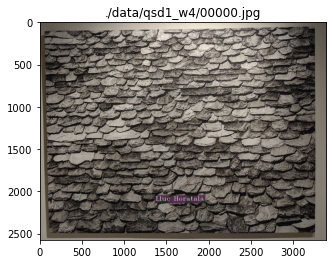

In [5]:
for img, filename in zip(qsd1_w4, qsd1_w4_files):
    plt.imshow(img)
    plt.title(filename)
    break # show only 1 image

## Preprocessing: Noise Reduction

In [6]:
DENOISE = True

if DENOISE: 
    qsd1_w4 = denoise_images(qsd1_w4,method='nlmeans', ksize=(3,3))

100%|██████████| 30/30 [02:28<00:00,  4.96s/it]


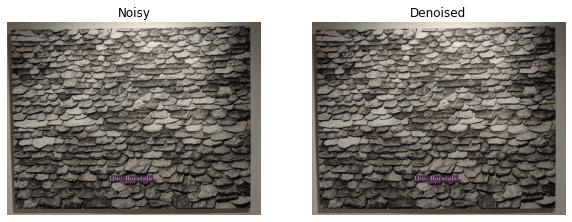

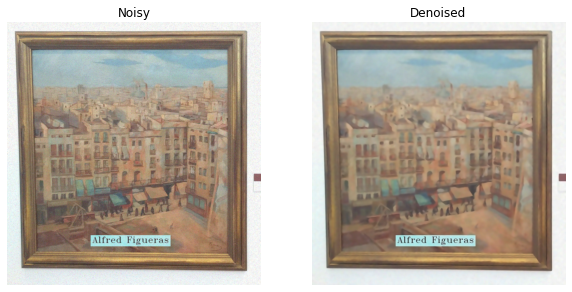

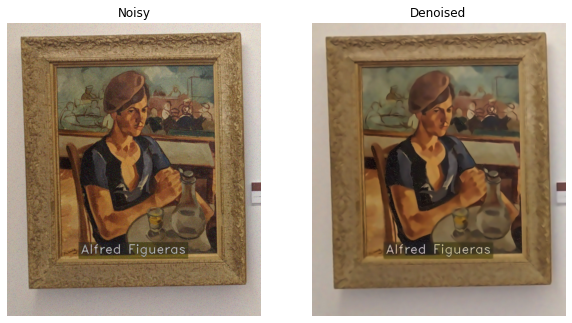

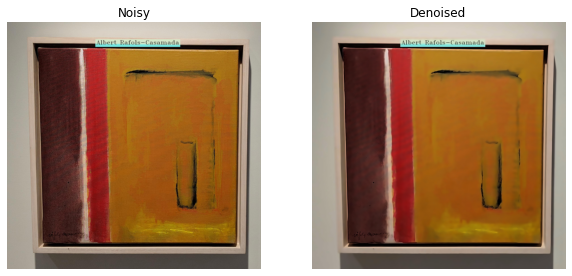

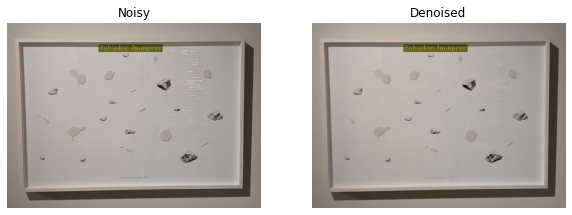

In [7]:
for den_img, filename in zip(qsd1_w4[:5], qsd1_w4_files[:5]):
    
    img = readimg(filename)
    
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(img)
    axarr[0].title.set_text("Noisy")
    axarr[0].axis('off')
    axarr[1].imshow(den_img)
    axarr[1].title.set_text("Denoised")
    axarr[1].axis('off')
    plt.show()

## Step 1) Crop, background removal and obtain the pictures.

In [8]:
DO_BKGCROP = True

In [9]:
new_qsd1_w4, new_qsd1_w4_files = background_crop (files= qsd1_w4_files, gt_masks= True,  save_masks = False, plot_results=False)


>> Mean IOU Score:  0.785066973644934


In [10]:
if DO_BKGCROP: 
    qsd1_w4, qsd1_w4files = new_qsd1_w4, new_qsd1_w4_files


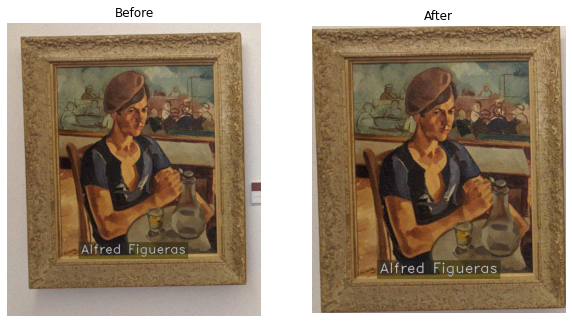

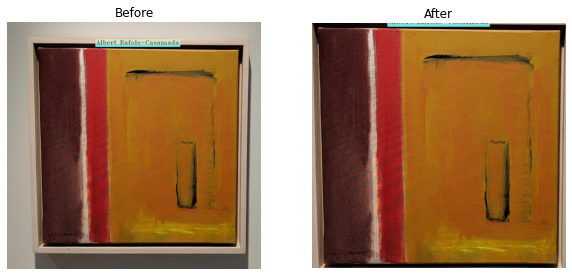

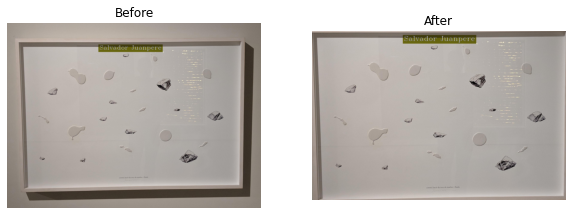

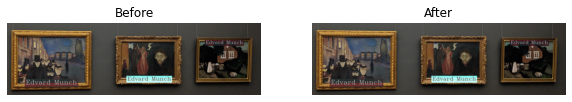

In [11]:
for img, filename in zip(qsd1_w4[2:6], qsd1_w4_files[2:6]):
    base = readimg (filename)
    
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(base)
    axarr[0].title.set_text("Before")
    axarr[0].axis('off')
    axarr[1].imshow(img)
    axarr[1].title.set_text("After")
    axarr[1].axis('off')
    plt.show()

## Step 2) Text Removal using crops

In [12]:
DO_TEXT_REMOVAL = True

In [13]:
#Method to remove text from the image with a rectangle 0 mask
if DO_TEXT_REMOVAL:
    qsd1_w4,contours = text_removal(qsd1_w4,num_images= 3, method='transparent', desc = 'Removing text of images') 

Removing text of images: 100%|██████████| 33/33 [00:06<00:00,  5.50it/s]
d:\Documentos\Team8\utils\image_processing.py:303: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(text_removed_image),contours


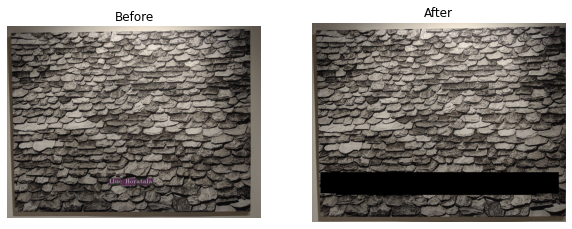

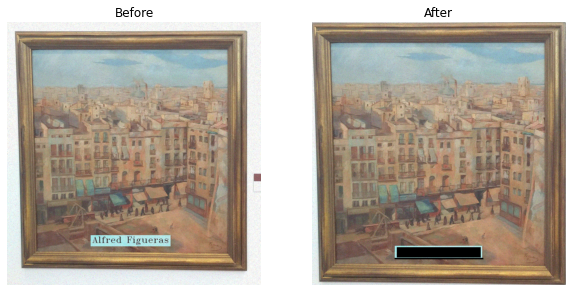

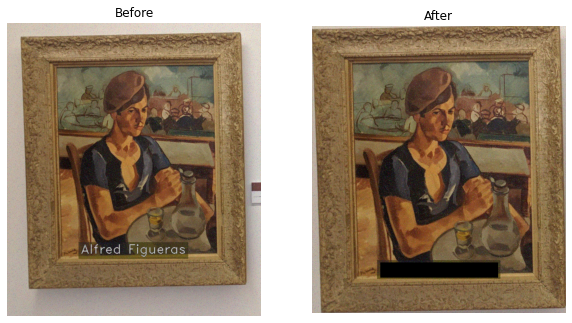

In [14]:
for img, filename in zip(qsd1_w4[:3], qsd1_w4_files[:3]):
    base = readimg (filename)
    
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(base)
    axarr[0].title.set_text("Before")
    axarr[0].axis('off')
    axarr[1].imshow(img)
    axarr[1].title.set_text("After")
    axarr[1].axis('off')
    plt.show()

## Step 3) Feature extraction

In [15]:
NBINS = 16
NCOLS = 8
NROWS = 8
BLOCK = True

COLOR   = False
TEXTURE = False
LOCAL = True

In [17]:
db_color_matrix = calculate_histograms(data = db, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc="Normalized 3D Histograms Calculation for BBDD...")
qsd1_w4_color_matrix = calculate_histograms(data = qsd1_w4, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qs1_w4...")


db_texture_matrix = calculate_hog(data = db, desc="Histogram of Gradient (HoG) for BBDD...")
qsd1_w4_texture_matrix = calculate_hog(data = qsd1_w4, desc = "Histogram of Gradient (HoG) for qsd1_w2...")

#db_local_matrix = calculate_orb(data = db, desc="ORB for BBDD...")
#qsd1_w4_local_matrix = calculate_orb(data = db, desc="ORB for qsd1_w4...")

db_keypoints, db_local_matrix = calculate_sift(data = db, desc="SIFT for BBDD...")
qsd1_w4_keypoints, qsd1_w4_local_matrix = calculate_sift(data = qsd1_w4, desc="SIFT for qsd1_w4...")


if COLOR:
    db_feature_matrix = db_color_matrix
    qsd1_w4_feature_matrix = qsd1_w4_texture_matrix 
    
if TEXTURE:
    # HoG @  32s
    db_feature_matrix = db_texture_matrix
    qsd1_w4_feature_matrix = qsd1_w4_texture_matrix

if LOCAL:
    # HoG @  32s
    db_feature_matrix = db_local_matrix
    qsd1_w4_feature_matrix = qsd1_w4_local_matrix 
    

SIFT for qsd1_w4...: 100%|██████████| 33/33 [00:15<00:00,  2.10it/s]


In [30]:
db_local_matrix[0].shape

(3172, 128)

In [29]:
print(db_local_matrix[1])

None


In [31]:
print (f'For each of the {len(qsd1_w4_feature_matrix)} images, we have a {qsd1_w4_feature_matrix[0].shape} dimensional descriptor')

For each of the 33 images, we have a (127840, 128) dimensional descriptor


In [32]:
# Similarity
sim = Similarity()
qs1_w4_similarities  = sim.compute_similarities(qs = qsd1_w4_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qs1_w4 similarities...", similarity = 'hellinger')

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix_iterator.cpp:71: error: (-215:Assertion failed) A.size == arrays[i0]->size in function 'cv::NAryMatIterator::init'


In [ ]:
# Get top K
K = 10

top_k_qs1_w4 = sim.get_top_k(similarity_matrix = qs1_w4_similarities, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")

### Validation Scores

In [ ]:
SAVE_RESULTS = False

for K in [10,5,1]:

    predicted_results = data_manager.save_results_1(results = top_k_qs1_w4, path = "./week4/QSD1/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
    #predicted_results = data_manager.fix_multi_image(results = predicted_results, results_files = qsd1_w4_files)
    expected_results = pickle.load(file = open('./data/qsd1_w4/gt_corresps.pkl', "rb"))
    metric = metrics.mapk(actual = expected_results, predicted = predicted_results, k=K)
    print("QSD1-W4 MAP@{} Score: {:.4f} ({}/{})".format(K, metric,int(len(predicted_results)*metric),len(predicted_results)))
    
    print (20 * '---')

In [ ]:
plot_image_and_similar(qsd1_w4,top_k_qs1_w4)